In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import liana as li
from liana.method._pipe_utils._common import _get_props
from liana.method.sp._utils import _add_complexes_to_var
from liana._logging import _logg
from liana.method._pipe_utils import prep_check_adata, assert_covered
from scipy.sparse import csr_matrix

# note squidpy is needed for autocorrelation / svgs
import squidpy as sq

/data/ddimitrov/software/miniforge3/envs/kiara2/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
/data/ddimitrov/software/miniforge3/envs/kiara2/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored


In [2]:
adata = sc.read_h5ad("nanostring_cosmx_human_nsclc_batch8.h5ad")
li.ut.spatial_neighbors(adata=adata, bandwidth=100)

In [3]:
sq.gr.spatial_autocorr(adata, mode='moran', use_raw=False)

In [4]:
# NOTE: use some arbitrary I to actually filter, p-values for such metrics are useless imo
# NOTE: @Moeed, if you are to use SVGs, I would recommend using a union of SVGs across all slides - you would need the same gene names across all slides (also same LRs, tbd)
svgs = adata.uns['moranI'].index[(adata.uns['moranI']['pval_norm_fdr_bh'] < 0.05) & (adata.uns['moranI']['I'] > 0.01)]
adata = adata[:, svgs]

In [5]:
global_res, lrdata = li.mt.inflow(adata,  
                                  groupby='cell_type',
                                  resource_name='cellchatdb',
                                  transform=li.ut.zi_minmax,
                                  use_raw=False, 
                                  cutoff=0.001)
lrdata.shape

/data/ddimitrov/software/miniforge3/envs/kiara2/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/data/ddimitrov/repos/liana-py/liana/method/sp/_inflow/inflow.py:184: RuntimeWarning: invalid value encountered in divide


(76536, 1736)

In [6]:
# Summed by the cell types (this is tetravariate essentially)
global_res.sort_values('value').tail() # NOTE: should correspond to the most commonly expressed (by cell type)

,name,value
17304,tumor^COL1A1^ITGA3_ITGB1^tumor,0.052591
17309,tumor^COL6A2^ITGA3_ITGB1^tumor,0.061601
17190,tumor^AREG^EGFR^tumor,0.068013
11516,myeloid^SPP1^CD44^myeloid,0.074333
17281,tumor^APP^CD74^tumor,0.149213


In [ ]:
sq.gr.spatial_autocorr(lrdata, mode='moran', use_raw=False)
svgs = lrdata.uns['moranI'].index[(lrdata.uns['moranI']['pval_norm_fdr_bh'] <= 0.05) & (lrdata.uns['moranI']['I'] > 0.01)]
lrdata = lrdata[:,svgs]
lrdata.uns['moranI'].sort_values("I").tail(10)

/data/ddimitrov/software/miniforge3/envs/kiara2/lib/python3.10/site-packages/squidpy/gr/_utils.py:203: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


,I,pval_norm,var_norm,pval_norm_fdr_bh
plasmablast^APP^CD74,0.548266,0.0,0.000001,0.0
endothelial^APP^CD74,0.555749,0.0,0.000001,0.0
NK/T cell^APP^CD74,0.599667,0.0,0.000001,0.0
myeloid^APP^CD74,0.661180,0.0,0.000001,0.0
tumor^APP^CD74,0.780448,0.0,0.000001,0.0


In [8]:
adata.layers['transformed'] = li.utils.zi_minmax(adata.X, cutoff=0.01)

/tmp/ipykernel_2468359/3987365680.py:1: ImplicitModificationWarning: Setting element `.layers['transformed']` of view, initializing view as actual.


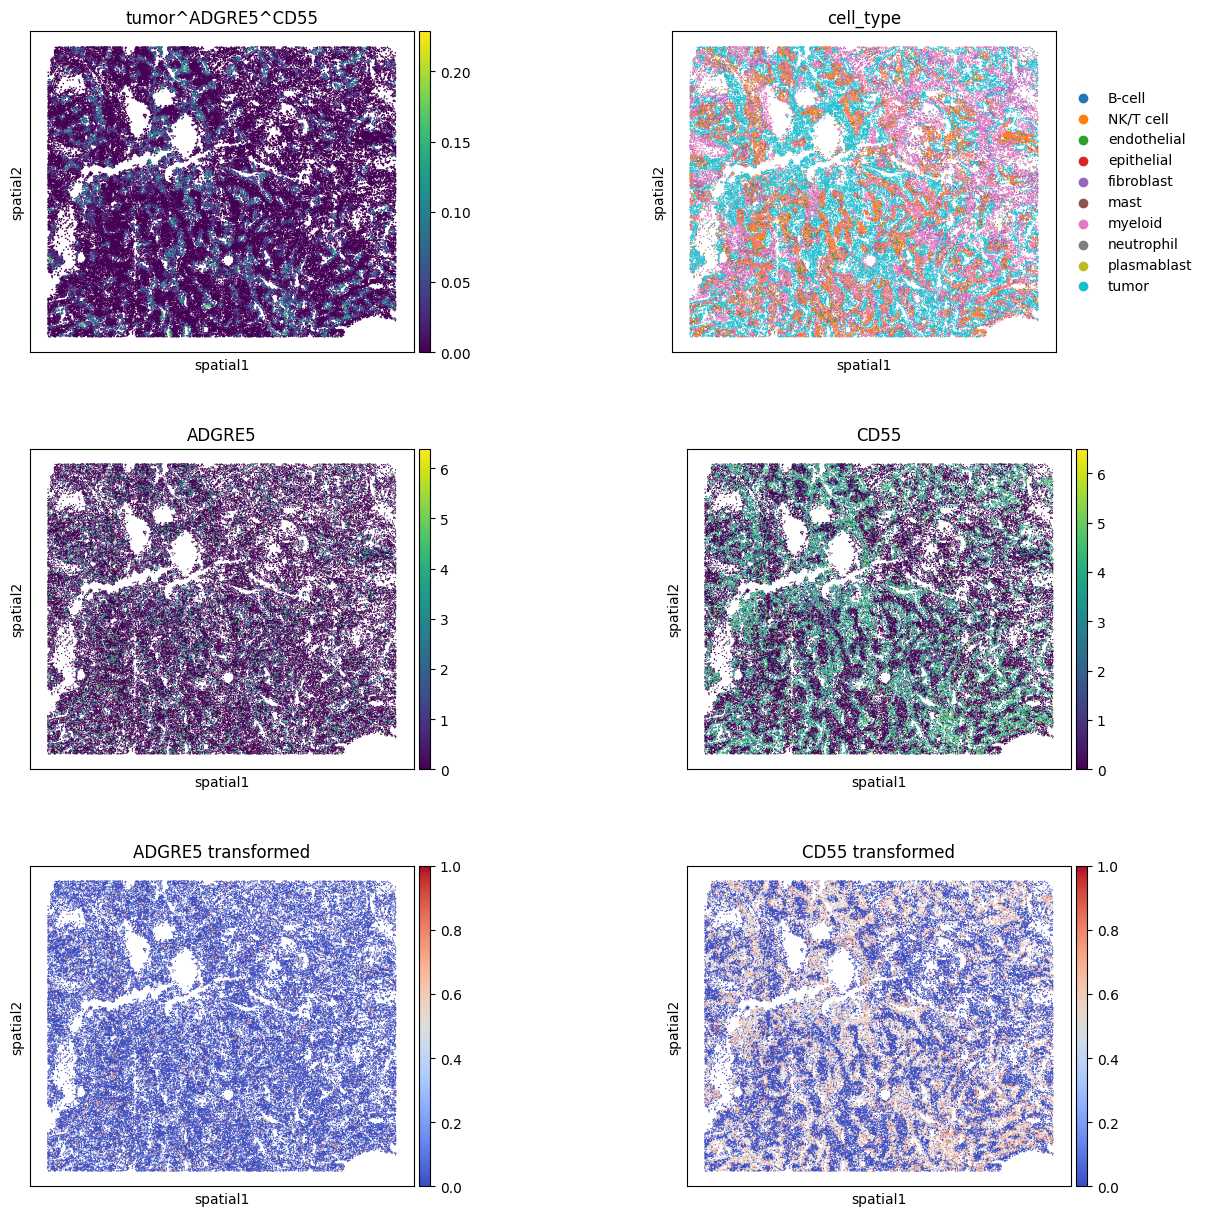

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()

# Define your keys
key = 'tumor^ADGRE5^CD55' #NOTE @Moeed, sanity check interaction for Macrophage infiltration
xy_sep = '^'
groupby = 'cell_type'
keys = key.split(xy_sep)

if len(keys) < 2:
    raise ValueError("The 'key' variable should contain at least two elements separated by '&'.")

ligand = keys[1]
receptor = keys[2]

adata.obs['receptor'] = (adata[:, receptor].X > 0).toarray().flatten()

sc.pl.spatial(lrdata, color=[key], spot_size=100, ax=axes[0],show=False)
axes[0].set_title(f"{key}")
sc.pl.spatial(adata, color=[groupby], spot_size=80, ax=axes[1],show=False)
axes[1].set_title(f"{groupby}")
sc.pl.spatial(adata, color=[ligand], spot_size=80, ax=axes[2], show=False)
axes[2].set_title(f"{ligand}")
sc.pl.spatial(adata, color=[receptor], spot_size=80, ax=axes[3], show=False)
axes[3].set_title(f"{receptor}")
sc.pl.spatial(adata, color=[ligand], spot_size=80, ax=axes[4], show=False, layer='transformed', cmap='coolwarm')
axes[4].set_title(f"{ligand} transformed")
sc.pl.spatial(adata, color=[receptor], spot_size=80, ax=axes[5], show=False, layer='transformed', cmap='coolwarm')
axes[5].set_title(f"{receptor} transformed")
plt.show()